In [ ]:
!pip install -q transformers
!pip install -q torch
!pip install -q fastai

     |████████████████████████████████| 2.0MB 5.7MB/s 
     |████████████████████████████████| 890kB 28.9MB/s 
     |████████████████████████████████| 3.2MB 36.7MB/s 


In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd

import os
import gc
import random
from functools import partial
from typing import List
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20.0, 8.0]
plt.rcParams.update({'font.size': 16,})

# pytorch
import torch
import torch.optim as optim

# sklearn
from sklearn.model_selection import train_test_split

# fastai
import fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from transformers import AdamW

# transformers
import transformers
from transformers import AdamW
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
songs = pd.read_csv("/content/drive/MyDrive/W266 NLP/Project/Music/cleaned_lyrics_final.csv")
del songs["Unnamed: 0"]
songs.dropna(subset=['lyrics'], inplace=True)
songs['year'] = songs['year'].astype(int)
songs.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing \nyou know i'm gonna cu...
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy \nit's like you seem...
2,honesty,2009,beyonce-knowles,Pop,if you search\nfor tenderness\nit isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i\n \nif i wrote a book a...
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's po...


In [ ]:
songs.shape

(223049, 5)

In [ ]:
# encode the genre labels
labels = songs.genre.unique()

label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index

songs['label'] = songs['genre'].map(label_dict)
songs.head()

,song,year,artist,genre,lyrics,label
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing \nyou know i'm gonna cu...,0
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy \nit's like you seem...,0
2,honesty,2009,beyonce-knowles,Pop,if you search\nfor tenderness\nit isn't hard t...,0
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i\n \nif i wrote a book a...,0
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's po...,0


In [ ]:
# split into train (90%) and test (10%)
# dev set will be split later from train (10%)
# final split: train (80%), dev (10%), test (10%)

train, test = train_test_split(songs, test_size=0.10, random_state=2021, stratify = songs.label.values)

In [ ]:
print('Number of songs in train:',train.shape[0])
print('Number of songs in test:',test.shape[0])

Number of songs in train: 200744
Number of songs in test: 22305


# Model Architecture Setup

**Main transformers classes**

In transformers, each model architecture is associated with 3 main types of classes:

1. A model class to load/store a pre-trained model.
2. A tokenizer class to pre-process the data and make it compatible with a particular model.
3. A configuration class to load/store the configuration of a particular model.

In order to switch easily between classes  -  each related to a specific model type  -  I created a dictionary that allows loading the correct classes by just specifying the correct model type.

In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [ ]:
# define parameters

seed = 42 
use_fp16 = False
bs = 16 # batch_size

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'albert'
#pretrained_model_name = 'albert-large-v2'# albert-base-v2

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
# set seed for all for reproducibility

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(seed)

## Data pre-processing
We have to format the model input sequence in a specific format prior to training. 
- Tokenize and then numericalize the texts correctly. The tokenizer class from transformers provides the correct pre-process tools that correspond to each pre-trained model.
- In the fast.ai library, data pre-processing is done automatically during the creation of the DataBunch. In the DataBunch implementation, the tokenizer and numericalizer are passed in the processor argument under the following format:

> `processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]`

**Custom Tokenizer**

A tokentizer takes the text and transforms it into tokens. The fastai documentation notes that:

- The TokenizeProcessor object takes as tokenizer argument a Tokenizer object.
- The Tokenizer object takes as tok_func argument a BaseTokenizer object.
- The BaseTokenizer object implement the function tokenizer(t:str) → List[str] that take a text t and returns the list of its tokens.
- Therefore, we can simply create a new class TransformersBaseTokenizer that inherits from BaseTokenizer and overwrite a new tokenizer function.

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'roberta', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.model_max_length
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the special tokens (CLS and SEP)"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

Text pre-processing requirements for the 5 models

> bert:       [CLS] + tokens + [SEP] + padding
>
> roberta:    [CLS] + prefix_space + tokens + [SEP] + padding
>
>distilbert: [CLS] + tokens + [SEP] + padding
>
>albert:        [CLS] + tokens + [SEP] + padding
>
>xlnet:      padding + tokens + [SEP] + [CLS]

### Custom Numericalizer

In fastai, NumericalizeProcessor object takes as vocab argument a Vocab object. From this analyse, we suggest two ways to adapt the fastai numericalizer.The numericalizer takes the the tokens, and turns them into numbers. The fastai documentation notes that:

- The NumericalizeProcessor object takes as vocab argument a Vocab object
To use the RoBERTa numericalizer, we create a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions.

Thus, we create a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions.

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

## Process Data
Now that we have a custom processor, which contains the custom tokenizer and numericalizer, we can create the DataBunch. During the DataBunch creation, we have to pay attention to set the processor argument to our new custom processor transformer_processor and manage correctly the padding.

Per HuggingFace documentation, BERT, RoBERTa, ALBERT and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. For XLNET, it has relative position embeddings, so we can either pad the inputs on the left or right.

In [ ]:
# pad left if model type is XLENT, else pad right

pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
# unit testing

tokens = transformer_tokenizer.tokenize('w266 final project: lyric classification')
print(tokens)

ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)

transformer_tokenizer.convert_ids_to_tokens(ids)

['w', '266', 'Ġfinal', 'Ġproject', ':', 'Ġlyric', 'Ġclassification']
[605, 31353, 507, 695, 35, 28865, 20257]


['w', '266', 'Ġfinal', 'Ġproject', ':', 'Ġlyric', 'Ġclassification']

In the DataBunch, we pass `lyrics` as the input text, `genre` as the label, the test DataFrame as the test set, and take 15% of train into the dev set.

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

databunch = (TextList.from_df(train, cols='lyrics', processor=transformer_processor)
             .split_by_rand_pct(0.10,seed=seed)
             .label_from_df(cols='genre')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
# test tokenizer and batch

# print('[CLS] token :', transformer_tokenizer.cls_token)
# print('[SEP] token :', transformer_tokenizer.sep_token)
# print('[PAD] token :', transformer_tokenizer.pad_token)

# databunch.show_batch()

In [ ]:
# test numericalizer and batch

# print('[CLS] id:', transformer_tokenizer.cls_token_id)
# print('[SEP] id:', transformer_tokenizer.sep_token_id)
# print('[PAD] id:', pad_idx)

# test_one_batch = databunch.one_batch()[0]
# print('Batch shape: ',test_one_batch.shape)
# print(test_one_batch)

## Create Model
Each model's forward method always outputs a tuple with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits via a custom model.

In [ ]:
# define model architecture 

class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        logits = self.transformer(input_ids, attention_mask = attention_mask)[0]   
        return logits

To adapt our transformers to multiclass classification, we define the number of labels before loading the pre-trained model by modifying the config instance of the pre-trained mdodel.

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = len(label_dict)
config.use_bfloat16 = use_fp16
print(config)


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformer

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

## Define Learner and Optmizer
In fastai, the Learner holds the data, model and other parameter, like the optimizer. Since we're using transformers, we want to use an optimizer designed for them: the AdamW optimizer. This optimizer matches PyTorch Adam optimizer API, therefore, it becomes straightforward to integrate it within fastai. To reproduce BertAdam specific behavior, we set `correct_bias = False`.

In [ ]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[FBeta(beta = 1, average='weighted'), Precision(average='weighted'), Recall(average='weighted'),accuracy, error_rate],
                  callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=2)]) # FBeta equivalent to f1_score if beta = 1

# show graph of learner stats and metrics after each epoch
learner.callbacks.append(ShowGraph(learner))

if use_fp16: learner = learner.to_fp16()

In [ ]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (d

## Model Training

In [ ]:
# create layers

roberta_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.classifier]

In [ ]:
# check groups

learner.split(roberta_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

In [ ]:
learner.save('untrain')

In [ ]:
seed_all(seed)
learner.load('untrain');

In [ ]:
# first freeze all groups except the classifier head to find approriate starting learning rate
learner.freeze_to(-1)

In [ ]:
# check for trainable layers
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           38,603,520 False     
______________________________________________________________________
Embedding            [512, 768]           394,752    False     
______________________________________________________________________
Embedding            [512, 768]           768        False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

In [ ]:
# alternative to fastai's lr finder

def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [ ]:
find_appropriate_lr(learner)
gc.collect()

epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


0

Min numerical gradient: 3.31E-04
Min loss divided by 10: 1.20E-04


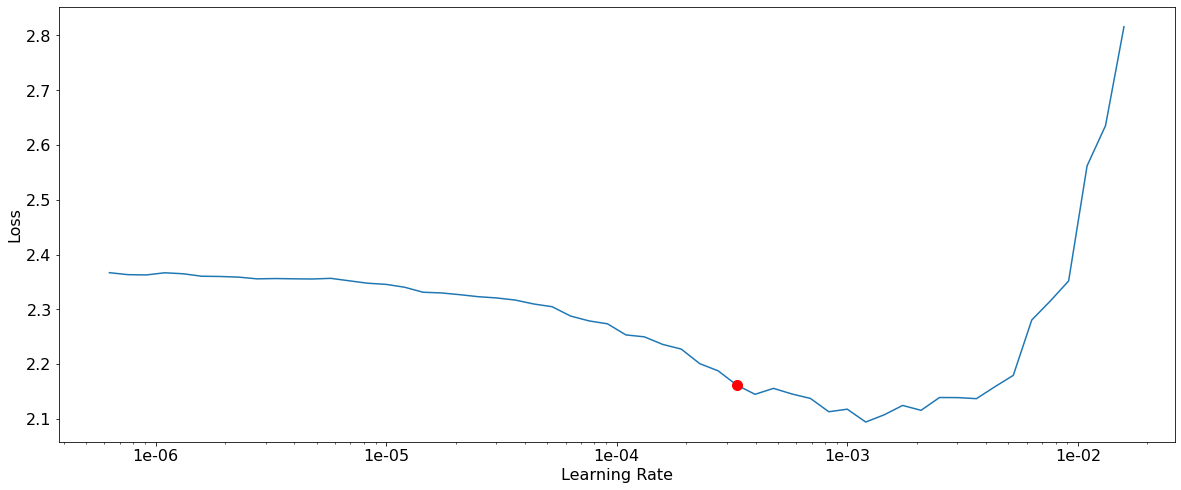

In [ ]:
learner.recorder.plot(skip_end=7,suggestion=True)

For Slanted Triangular Learning Rates, we have to use the function one_cycle. To use `one_cycle`, we will need an optimum learning rate. We can find this learning rate by using a learning rate finder, which can be called by using `lr_find`.

In [ ]:
learner.lr_find()
gc.collect()

epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


0

Min numerical gradient: 1.58E-04
Min loss divided by 10: 4.37E-04


8

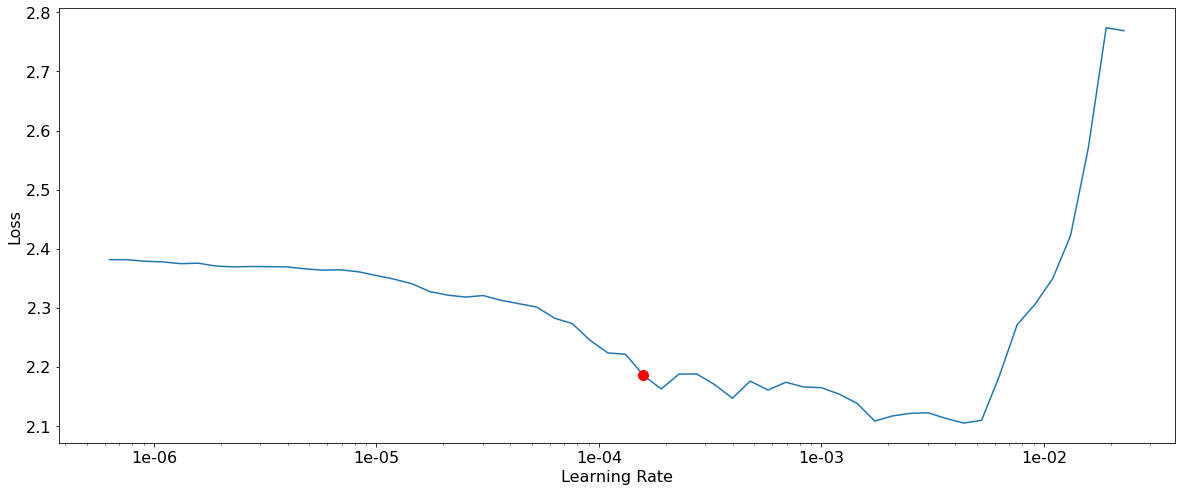

In [ ]:
learner.recorder.plot(skip_end=7,suggestion=True)
gc.collect()

In [ ]:
# training params
unfreeze_layers = [-1,-2,-3,-4,-5,-6,-8,-10,-12,-13,-14]
learning_rates = [3e-5, 1e-5, 5e-6, 3e-6, 1e-6,5e-7,3e-7, 1e-7, 5e-8, 3e-8, 1e-8]
epochs = [1,1,1,1,1,1,1,1,1,1,1]

In [ ]:
def dlt():
    for layer in range(0,len(unfreeze_layers)):
        learner.freeze_to(unfreeze_layers[layer])
        print('freezing to:',unfreeze_layers[layer],' - ',epochs[layer],'epochs')
        learner.fit_one_cycle(epochs[layer], 
                              max_lr=slice(learning_rates[layer]*0.95**num_groups, learning_rates[layer]),
                              moms=(0.8, 0.9))
        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_confusion_matrix(figsize=(26,10))
        learner.save('cycle_'+str(layer))

freezing to: -1  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.437218,1.395479,0.433899,nan,0.547923,0.547923,0.452077,20:14


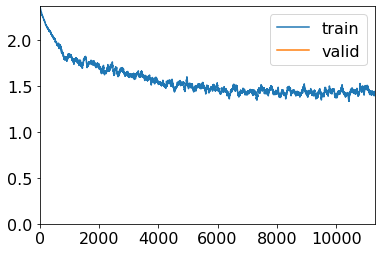

freezing to: -2  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.303099,1.242953,0.542164,nan,0.600030,0.600030,0.399970,26:27


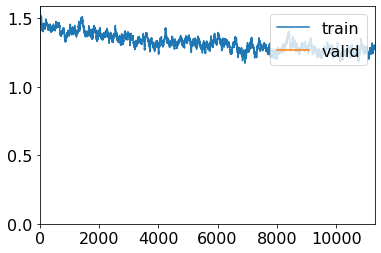

freezing to: -3  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.236944,1.212540,0.556530,nan,0.609096,0.609096,0.390904,25:03


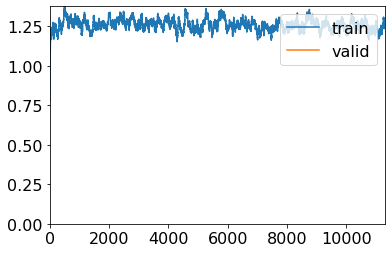

freezing to: -4  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.242396,1.192636,0.566003,nan,0.615871,0.615871,0.384129,30:35


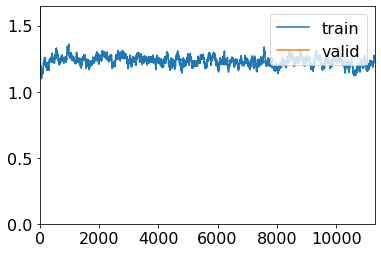

freezing to: -5  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.220115,1.183931,0.570951,nan,0.618561,0.618561,0.381439,33:53


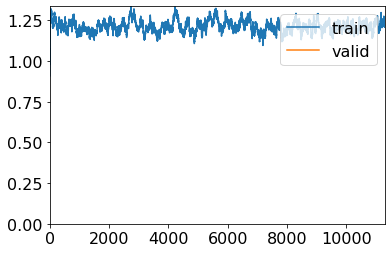

freezing to: -6  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.276156,1.180485,0.571885,nan,0.619757,0.619757,0.380243,36:17


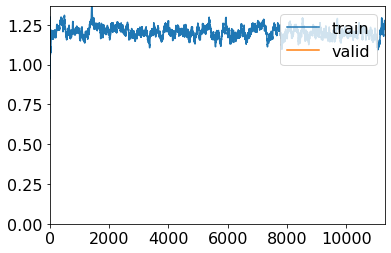

freezing to: -8  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.174915,1.176900,0.573069,nan,0.620703,0.620703,0.379297,39:28


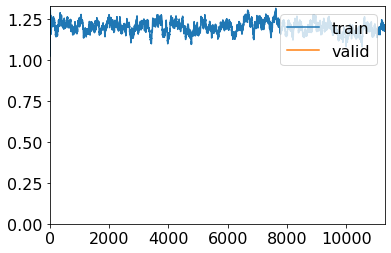

freezing to: -10  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.168920,1.175751,0.574759,nan,0.620903,0.620903,0.379097,46:20


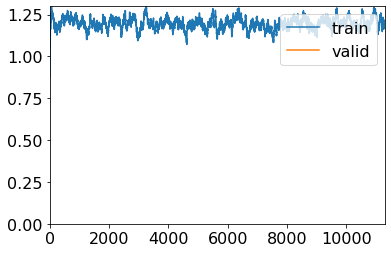

freezing to: -12  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.195400,1.174773,0.575467,nan,0.621700,0.621700,0.378300,50:00


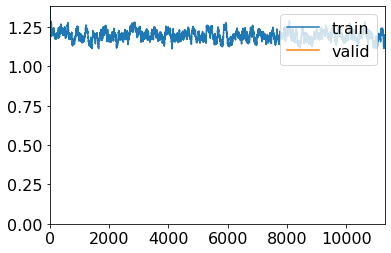

freezing to: -13  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.205692,1.174152,0.575020,nan,0.621500,0.621500,0.378500,1:02:57


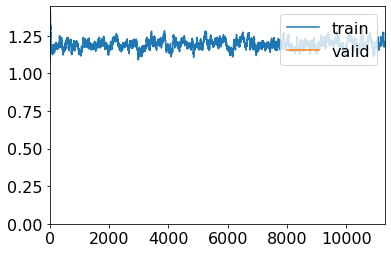

freezing to: -14  -  1 epochs


epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.207879,1.173766,0.575970,nan,0.621849,0.621849,0.378151,1:04:49


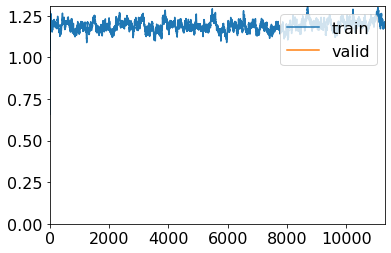

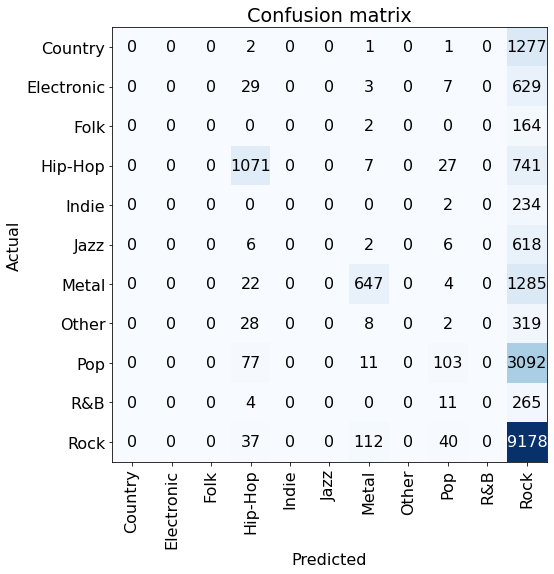

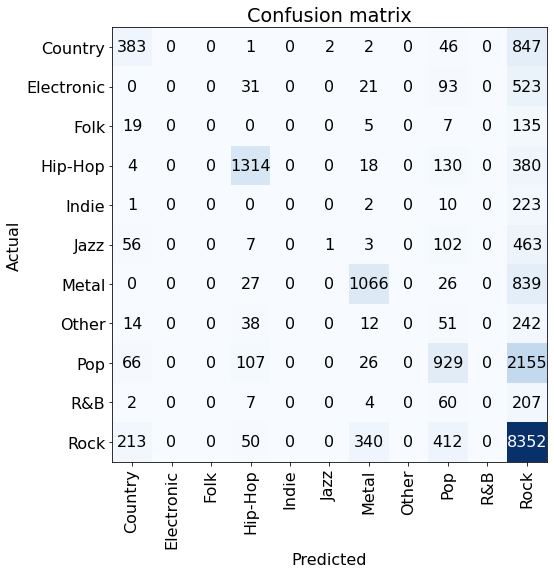

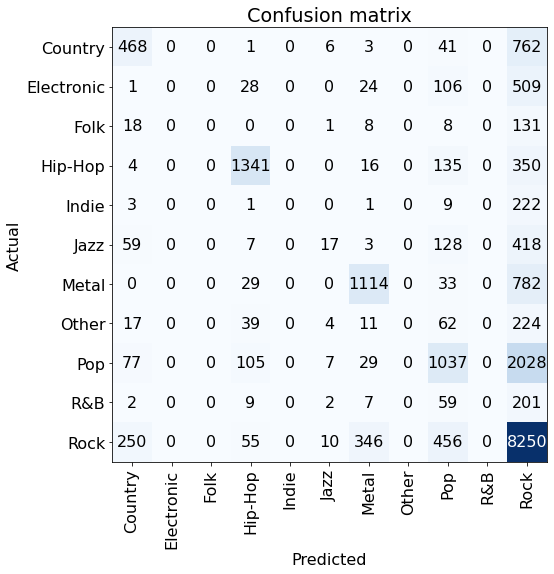

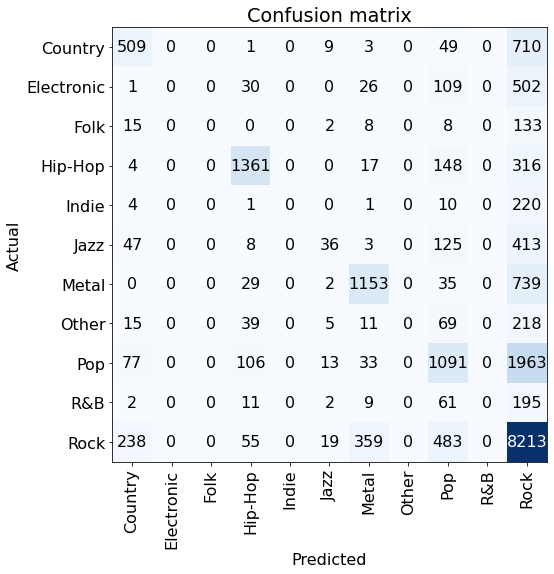

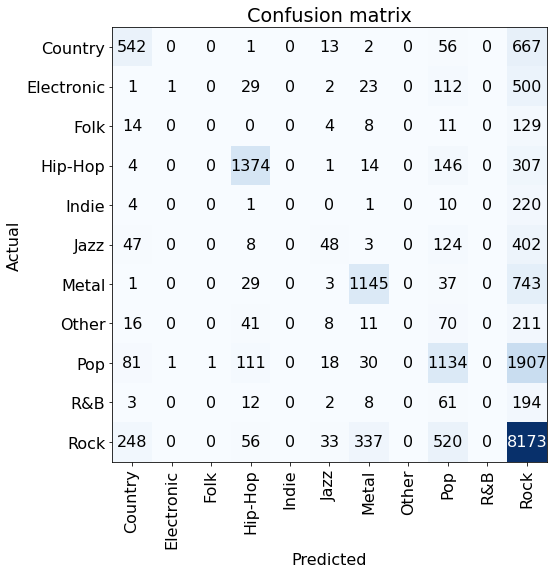

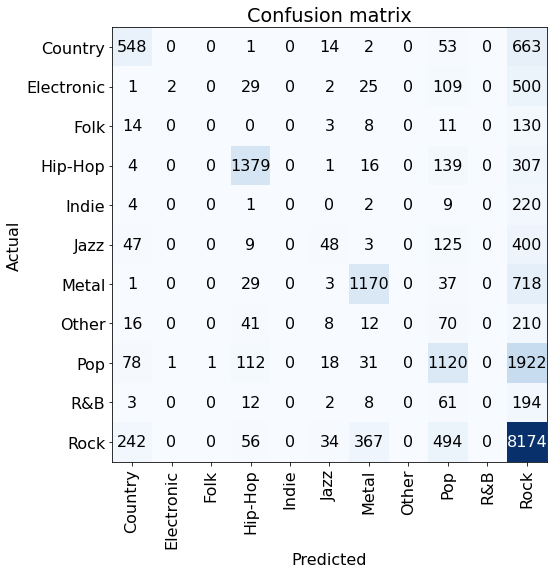

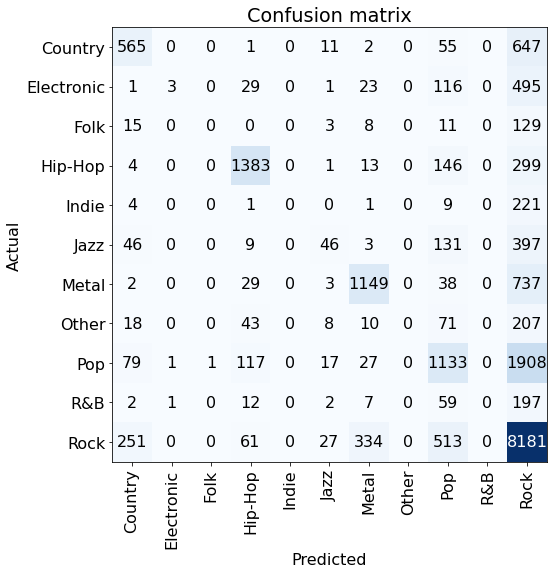

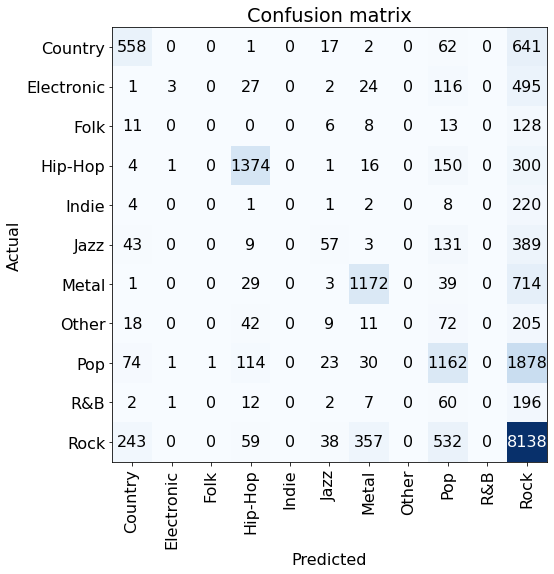

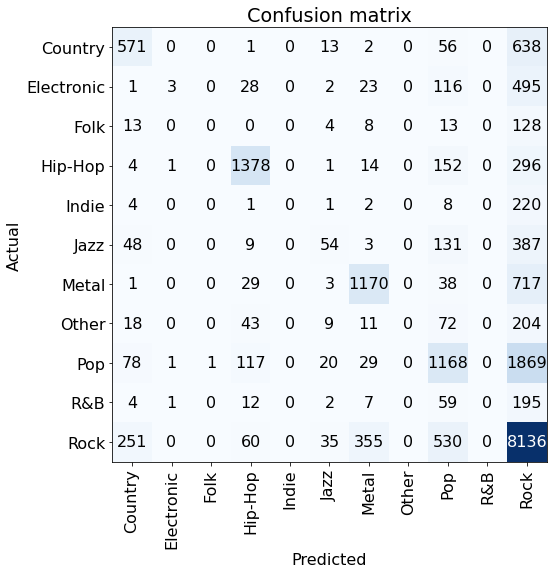

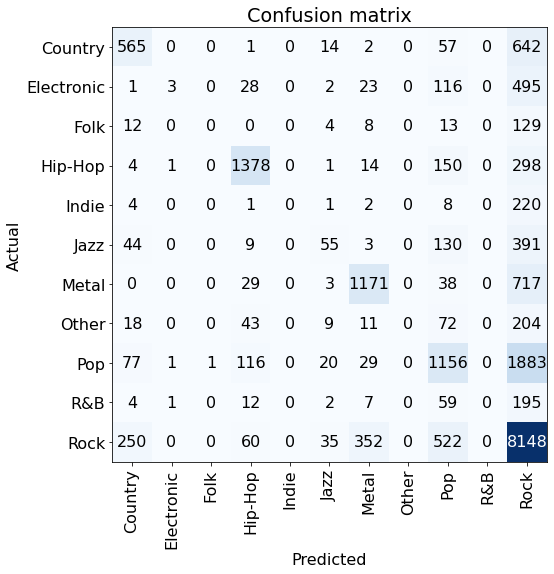

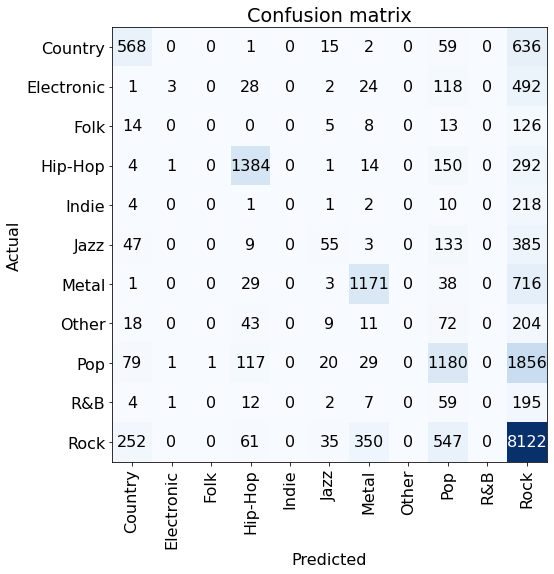

In [ ]:
dlt()

epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.170697,1.156499,0.595071,nan,0.623991,0.623991,0.376009,55:59
1,1.096702,1.084040,0.618847,nan,0.646956,0.646956,0.353044,1:05:16
2,0.906361,1.070066,0.635712,0.631495,0.656122,0.656122,0.343878,55:32


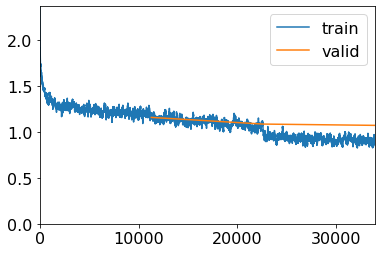

In [ ]:
# train model with 3 epochs

gc.collect()
learner.unfreeze()
learner.fit_one_cycle(3,max_lr=3e-5,moms=(0.8,0.9))

epoch,train_loss,valid_loss,f_beta,precision,recall,accuracy,error_rate,time
0,1.182053,1.175593,0.585452,nan,0.618511,0.618511,0.381489,1:37:13
1,1.132891,1.096983,0.615347,nan,0.646807,0.646807,0.353193,1:54:06
2,0.956944,1.069964,0.633264,nan,0.655226,0.655226,0.344774,1:36:17
3,0.814064,1.109795,0.639982,0.637997,0.655325,0.655325,0.344675,1:45:59


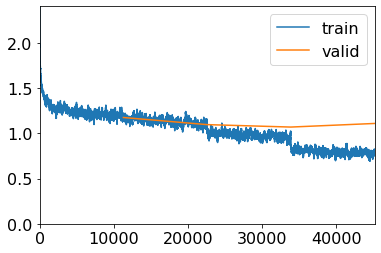

In [ ]:
# train model with 4 epochs

gc.collect()
learner.unfreeze()
learner.fit_one_cycle(4,max_lr=3e-5,moms=(0.8,0.9))

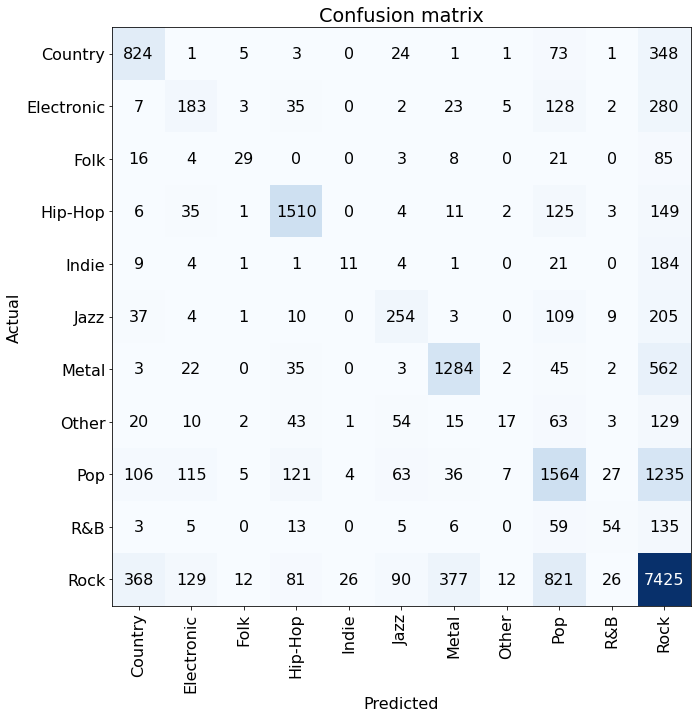

In [ ]:
# confusion matrix

interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(26,10))

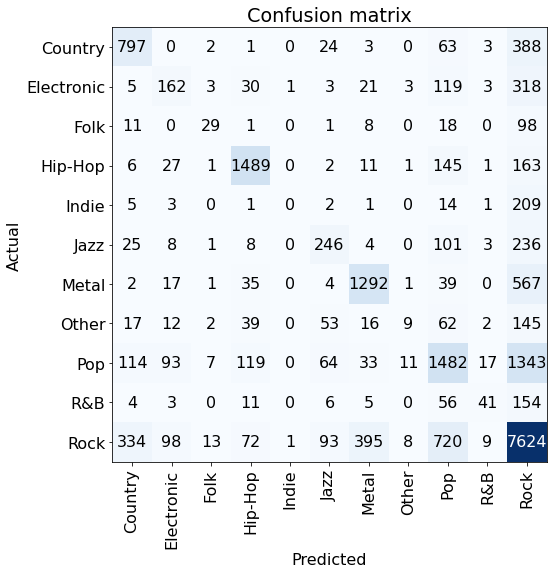

In [ ]:
# confusion matrix

interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(20,8))

epoch,train_loss,valid_loss,f_beta,accuracy,error_rate,time
0,1.187034,1.169109,0.587307,0.619558,0.380442,1:35:45
1,1.093956,1.075847,0.623065,0.651290,0.348710,1:52:37
2,0.909924,1.066624,0.637840,0.658314,0.341686,1:34:53


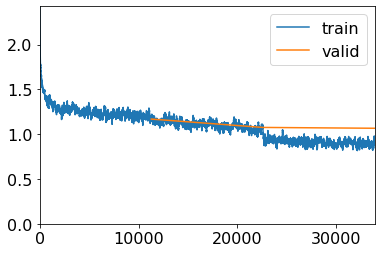

808

In [ ]:
# train model with 3 epochs
# learner.fit_one_cycle(3,max_lr=3e-5,moms=(0.8,0.9))

# gc.collect()